# Pair Trading Model
François GOUJON

Pair trading model: find dislocations between two underlying using daily closes. The idea is to go Long one vs. Short the other. <br>
We assume that stocks have one price a day (close) and we can only trade on that price. <br>

- (ASML NA) ASML HOLDING NV --> (ASML.AS)
- (BESI NA) BE SEMICONDUCTOR INDUSTRIES --> (BESI.AS)
- (IFX GY) INFINEON TECHNOLOGIES AG --> (IFX.DE)
- (GLE FP) SOCIETE GENERALE SA --> (GLE.PA)
- (INGA NA) ING GROEP NV --> (INGA.AS)
- (ISP IM) INTESA SANPAOLO --> (ISP.MI)
- (ABI BB) ANHEUSER-BUSCH INBEV SA/NV --> (BUD)
- (RI FP) PERNOD RICARD SA --> (RI.PA)
- (BN FP) DANONE --> (BN.PA)

For stocks that move similarly (Correlated or Cointegrated), we check when there is a drop in this similarity : in this case, we long the underperforming asset and short the overperforming asset. The idea behind this strategy is that we expect the similarity between the two assets to come back to its usual level, meaning that the underperforming asset will pump and/or the overperforming asset will dump. Also, as we will short and long both assets with same nominal position value, this strategy is self funding and doesn't need any cash to be completed. (In reality there will be brokering costs and collateral needs).

## PROCESS : 

- Retreive data from Yahoo Finance. Take care to have the right ticker in order to have all prices in the same currency. (Here EUR)
    Except BUD which is not listed in Europe so we can't have prices directly in EUR. We use the EUR/USD pair to convert prices to EUR. We also have to take care of different open trading days in the EU and in the US. For closed days, returns will be fixed to 0. 
    
- Compute returns.

- Find highly correlated/cointegrated stocks to choose our trading pair : Asset A and B

- Extract a mean-reverting and stationnary process from A and B prices/returns to get signals.

- Take positions depending on signals. <br>
<br>

Mean-reverting and stationnary process : there are multiple ways to extract such process. I will try 2 different ideas : 

- Compute the spread between returns of A and B : return_A - return_B. If A and B follow the same movements then the spread will be close to 0. If the spread becomes positive then A outperformed B, else B outperformed A. 

- Compute the ratio between the price of A and B : price_A/price_B. If A and B follow the same movements then the ratio will be almost constant. When ratio goes above its mean then A outperformed B, else B outperformed A. 

In both cases we need to make sure that the process is stationnary and mean-reverting.
    

### Functions : 

In [1]:
# Imports
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint, adfuller

In [2]:
# Tickers dictionnary : stocks[ticker] = [FullName, Currency]
stocks = {"ASML.AS" : ["ASML HOLDING NV", "EUR"],
          "BESI.AS" : ["BE SEMICONDUCTOR INDUSTRIES", "EUR"],
          "IFX.DE" : ["INFINEON TECHNOLOGIES AG", "EUR"], 
          "GLE.PA" : ["SOCIETE GENERALE SA", "EUR"],
          "INGA.AS" : ["ING GROEP NV", "EUR"],
          "ISP.MI" : ["INTESA SANPAOLO", "EUR"], 
          "BUD" : ["ANHEUSER-BUSCH INBEV SA/NV", "USD"], 
          "RI.PA" : ["PERNOD RICARD SA", "EUR"], 
          "BN.PA" : ["DANONE", "EUR"]}

In [3]:
def get_stock_data(stocks, start = None, end = None, days = 365, logReturns=False):
    """
    Retrieve data from yfinance
    Output: price dataframe (pd.DataFrame), returns dataframe, normalized returns dataframe
    """
    tickers = " ".join(stocks.keys())
    tickers += ' USDEUR=X' # Add USD/EUR pair to change USD price in EUR
    if end is None:
        end = datetime.datetime.now()
    if start is None:
        start = end - datetime.timedelta(days=days+1)
    price_df = yf.Tickers(tickers).history(start=start, end=end, period="1d")
    price_df = price_df["Close"] 
    price_df.index = price_df.index.to_series().dt.date # Change index type from TimeStamp to date
    for tick in stocks:
        if stocks[tick][1] == "USD":
            print("Changing " + tick + " from USD to EUR")
            price_df[tick] = price_df[tick] * price_df["USDEUR=X"] # Change USD price to EUR price
    price_df.drop(["USDEUR=X"], axis = 1, inplace = True) # Dropping EUR/USD
    price_df.dropna(axis = 0, how = 'all', inplace = True) # Removing rows where only FX markets are open
    if logReturns:
        returns_df = np.log(price_df.pct_change(1) + 1)
    else:
        returns_df = price_df.pct_change(1) # pct_change sets by default 0 when there is a NaN so returns will be 0 for closed trading days
    returns_df.dropna(inplace=True)    
    dfs = {"price": price_df, "returns": returns_df}
    return dfs

def plot_data(df):
    """Plot time series"""
    fig, ax = plt.subplots(figsize=(16,5))
    df.plot(ax=ax)
    plt.show()

def plot_corr(returns):
    """Plot correlation of returns"""
    corr = returns.corr()
    fig, ax = plt.subplots(figsize=(16,5))
    im = ax.matshow(corr)
    fig.colorbar(im, ax=ax)
    plt.show()
    return corr

def findCorrelatedStocks(corr, threshold = 0.70):
    """Find the more correlated stocks to apply dislocation strategy"""
    sorted_corr = corr.unstack().sort_values(ascending=False)
    scorr_df = sorted_corr.to_frame().reset_index().rename(columns={"level_0": "Ticker_1", "level_1":"Ticker_2", 0: "Correlation"})
    scorr_df = scorr_df[scorr_df["Correlation"] != 1]
    scorr_df = scorr_df.drop_duplicates(subset="Correlation")
    scorr_df = scorr_df[scorr_df["Correlation"] >= threshold]
    return scorr_df

# Results

In [4]:
# Retriving and preprocessing data
data = get_stock_data(stocks, start="2018-01-01", end="2023-01-01")
pr, ret, = data["price"], data["returns"]

[*********************100%***********************]  10 of 10 completed
Changing BUD from USD to EUR


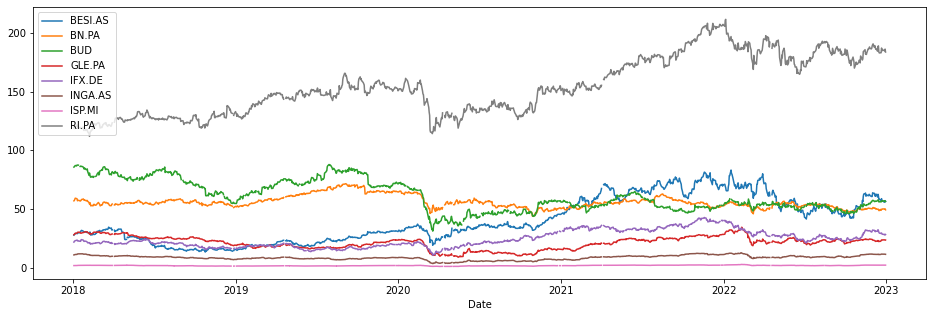

In [5]:
# Plot price (removed ASML because price to high to plot with the others)
plot_data(pr.drop(["ASML.AS"], axis=1))

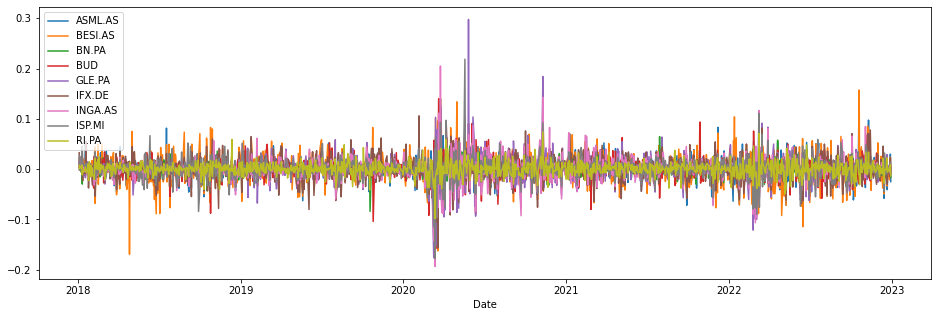

In [6]:
# Plot returns
plot_data(ret) 

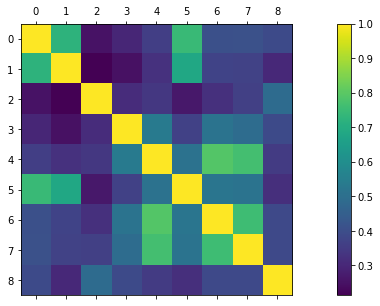

['ASML.AS', 'BESI.AS', 'BN.PA', 'BUD', 'GLE.PA', 'IFX.DE', 'INGA.AS', 'ISP.MI', 'RI.PA']


In [7]:
# Correlation heat map
corr = plot_corr(ret)
print(list(corr.columns))

In [8]:
# Highest correlation
findCorrelatedStocks(corr)

,Ticker_1,Ticker_2,Correlation
9,GLE.PA,INGA.AS,0.788819
11,ISP.MI,GLE.PA,0.764031
13,INGA.AS,ISP.MI,0.756323
15,ASML.AS,IFX.DE,0.747110
17,BESI.AS,ASML.AS,0.723241


## Pair analysis : 

In [9]:
def dislocationData(price, ret, tickA, tickB, st_window, lt_window):
    """Builds DF with data needed to implement strategy : price, returns, spread, ratio"""
    df = pd.merge(price[[tickA, tickB]], ret[[tickA, tickB]], left_index=True, right_index=True, suffixes=["_price", "_return"])
    df.rename(columns={tickA+"_price": "A_price", tickB+"_price": "B_price", tickA+"_return": "A_return", tickB+"_return": "B_return"}, inplace=True)
    df.dropna(inplace=True)
    # Spread
    df["spread"] = df["A_return"] - df["B_return"]
    df["rollSpread_ST"] = df["spread"].rolling(window = st_window).mean()
    df["rollSpread_LT"] = df["spread"].rolling(window = lt_window).mean()
    df["rollSpread_std_LT"] = df["spread"].rolling(window = lt_window).std()
    df["normSpread"] = (df["rollSpread_ST"] - df["rollSpread_LT"])/df["rollSpread_std_LT"]
    # Ratio
    df["ratio"] = df["A_price"]/df["B_price"]
    df["rollRatio_ST"] = df["ratio"].rolling(window = st_window).mean()
    df["rollRatio_LT"] = df["ratio"].rolling(window = lt_window).mean()
    df["rollRatio_std_LT"] = df["ratio"].rolling(window = lt_window).std()
    df["normRatio"] = (df["rollRatio_ST"] - df["rollRatio_LT"])/df["rollRatio_std_LT"]

    return df

def stationarity_test(ts, cutoff=0.01):
    # We need p-value close to 0 to convince ourselves that the series is stationary
    pvalue = adfuller(ts.dropna())[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' The series is likely stationary.')
    else:
        print('p-value = ' + str(pvalue) + ' The series is likely non-stationary.')

In [10]:
ds_df = dislocationData(pr, ret, "GLE.PA", "ISP.MI", 10, 60)

#### Method 1 : Spread of returns

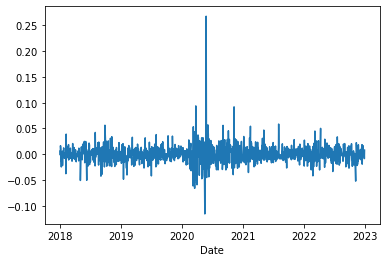

p-value = 2.9988694823064134e-19 The series is likely stationary.


In [11]:
ds_df["spread"].plot()
plt.show()
stationarity_test(ds_df["spread"])

Taking only the one day spread might be too sensible to noise (and will make us take a lot of positions meaning more costs). <br>
One way to prevent that would be to take a rolling mean of the spread : 

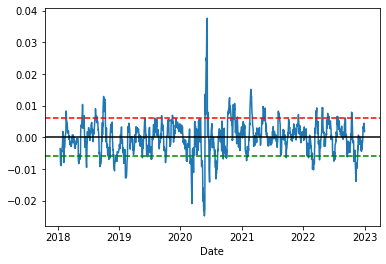

p-value = 2.629974696135001e-07 The series is likely stationary.


In [12]:
# Rolling mean with window of 10 days
ds_df["rollSpread_ST"].plot()
plt.axhline(0, color='black')
plt.axhline(.006, color='red', linestyle='--')
plt.axhline(-.006, color='green', linestyle='--')
plt.show()
stationarity_test(ds_df["rollSpread_ST"])

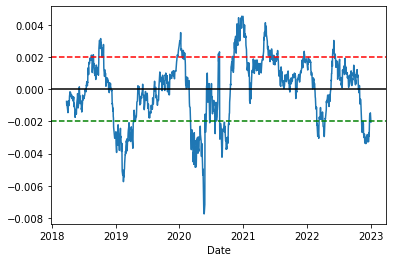

p-value = 0.0033029051057689674 The series is likely stationary.


In [13]:
# Rolling mean with window of 60 days : capturing longer term dislocations
ds_df["rollSpread_LT"].plot().plot()
plt.axhline(0, color='black')
plt.axhline(.002, color='red', linestyle='--')
plt.axhline(-.002, color='green', linestyle='--')
plt.show()
stationarity_test(ds_df["rollSpread_LT"])

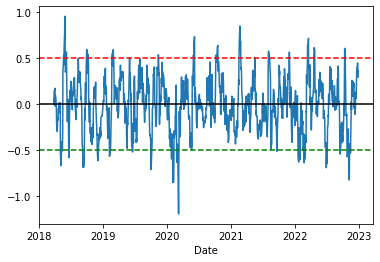

p-value = 8.866112358841014e-07 The series is likely stationary.


In [14]:
# Normalizing rolling spread to capture short term dislocation 
# Normalizing is also important so that we can choose a threshold value that doesn't depend on other parameters.
ds_df["normSpread"].plot()
plt.axhline(0, color='black')
plt.axhline(.5, color='red', linestyle='--')
plt.axhline(-.5, color='green', linestyle='--')
plt.show()
stationarity_test(ds_df["normSpread"])

There we can clearly see that the rolling spread seems to be a mean reverting and stationnary process.
A good threshold would be 0.5 : going back down(up) when crossing 0.5(-0.5).

#### Method 2 : Ratio of prices

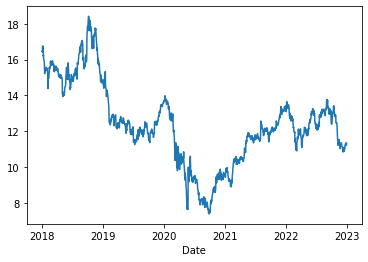

p-value = 0.27413323406922835 The series is likely non-stationary.


In [16]:
ds_df["ratio"].plot()
plt.show()
stationarity_test(ds_df["ratio"])

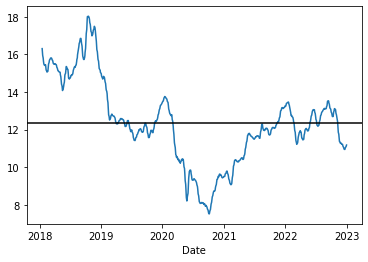

p-value = 0.33791072559151564 The series is likely non-stationary.


In [17]:
# Rolling mean with window of 10 days
ds_df["rollRatio_ST"].plot()
plt.axhline(np.mean(ds_df["rollRatio_ST"]), color='black')
plt.show()
stationarity_test(ds_df["rollRatio_ST"])

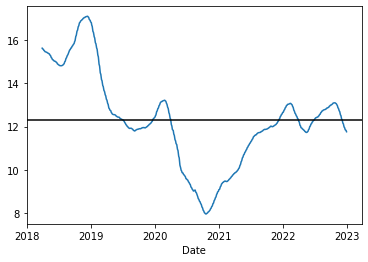

p-value = 0.1739342643303618 The series is likely non-stationary.


In [18]:
# Rolling mean with window of 60 days : capturing longer term dislocations
ds_df["rollRatio_LT"].plot()
plt.axhline(np.mean(ds_df["rollRatio_LT"]), color='black')
plt.show()
stationarity_test(ds_df["rollRatio_LT"])

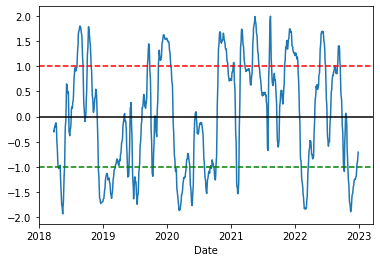

p-value = 0.0005200556437061641 The series is likely stationary.


In [19]:
# Normalizing rolling ratio to capture short term dislocation 
ds_df["normRatio"].plot()
plt.axhline(0, color='black')
plt.axhline(1, color='red', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')
plt.show()
stationarity_test(ds_df["normRatio"])

There we can clearly see that the rolling ratio seems to be a mean reverting and stationnary process.
A good threshold would be 1 : going back down(up) when crossing 1(-1).

### Strategy implementation : 

We build an algorithm which will implement the expected behavior : Short A/Long B when the normalized spread/ratio crosses the red line, and Long A/Short B when it crosses the green line. We close position at a desired close threshold, for example when the spread/ratio goes back to 0. <br>
We also have to choose the position size we take at each trade depending on our risk tolerance. <br>
Keep in mind that the we window sizes and threshold we choose have a great impact on the strategy.

In [20]:
def plot_indicator(dislo_df):
    """Plot rolling ratio and spread"""
    fig, axs = plt.subplots(2, 3, figsize=(20, 10))
    dislo_df["rollSpread_ST"].plot(ax=axs[0, 0])
    dislo_df["rollSpread_LT"].plot(ax=axs[0, 1])
    dislo_df["normSpread"].plot(ax=axs[0, 2])
    axs[0,0].set_title("Short term rolling mean on spread")
    axs[0,1].set_title("Long term rolling mean on spread")
    axs[0,2].set_title("Normalized rolling mean on spread")
    dislo_df["rollRatio_ST"].plot(ax=axs[1, 0])
    dislo_df["rollRatio_LT"].plot(ax=axs[1, 1])
    dislo_df["normRatio"].plot(ax=axs[1, 2])
    axs[1,0].set_title("Short term rolling mean on ratio")
    axs[1,1].set_title("Long term rolling mean on ratio")
    axs[1,2].set_title("Normalized rolling mean on ratio")
    for ax in axs.flatten(): ax.grid()
    plt.show()

def dislocationsSignal(dislo_data, method, open_threshold, close_threshold, position_size):
    """Returns dislocation signals dataframe and money gained with the strategy

    Args:
        dislo_data (DataFrame): data on the pair : prices, returns, spread and ratio
        method (String) : "ratio" or "spread"
        open_threshold (Number): threshold to open a position : open when indicator > open_threshold
        close_threshold (Number): threshold to close a position
        position_size (Number): Nominal position size of trade on each asset

    Returns:
        dataframe: dataframe contaning data on A and B, dislocation indicators, and strategy positions
    """
    if method == "ratio":
        col = "normRatio"
    elif method == "spread":
        col = "normSpread"
    else:
        raise("Method not supported")
    dislo_data.dropna(inplace=True) # Clean of the first rows when the rolling mean is NaN because of not enough data
    n = len(dislo_data)
    position = 0 # 0: Neutral ; 1: LongA/ShortB ; -1: ShortA/LongB
    amount_A = 0 
    amount_B = 0
    info = []
    for i in range(n):
        money = 0
        if position == 0:
            if dislo_data[col][i] > open_threshold:
                # A outperfoms B : we open position Short A, Long B 
                # Short 1 A and Long A/B B to have 0 cost
                position = -1
                amount_A = -(position_size/dislo_data["A_price"][i])
                amount_B = position_size/dislo_data["B_price"][i]
            elif dislo_data[col][i] < -open_threshold:
                # A underperforms B : we open position Long A, Short B
                position = 1
                amount_B = -(position_size/dislo_data["B_price"][i])
                amount_A = (position_size/dislo_data["A_price"][i])
        else:
            if (position == 1 and dislo_data[col][i] > -close_threshold) or (position == -1 and dislo_data[col][i] < close_threshold):
                # A gained back on B or B gained back on A : we close position
                money = amount_A*dislo_data["A_price"][i] + amount_B*dislo_data["B_price"][i]
                position = 0
                amount_A = 0
                amount_B = 0
        step = [position, amount_A, amount_B, money]
        info.append(step)
    info = pd.DataFrame(info, columns=["Position", "Amount_A", "Amount_B", "MoneyGained"], index=dislo_data.index)
    res = pd.merge(dislo_data, info, left_index=True, right_index=True)
    res["CumulativeGain"] = res["MoneyGained"].cumsum()
    res["CumulativeGain"].plot()
    plt.show()
    return res

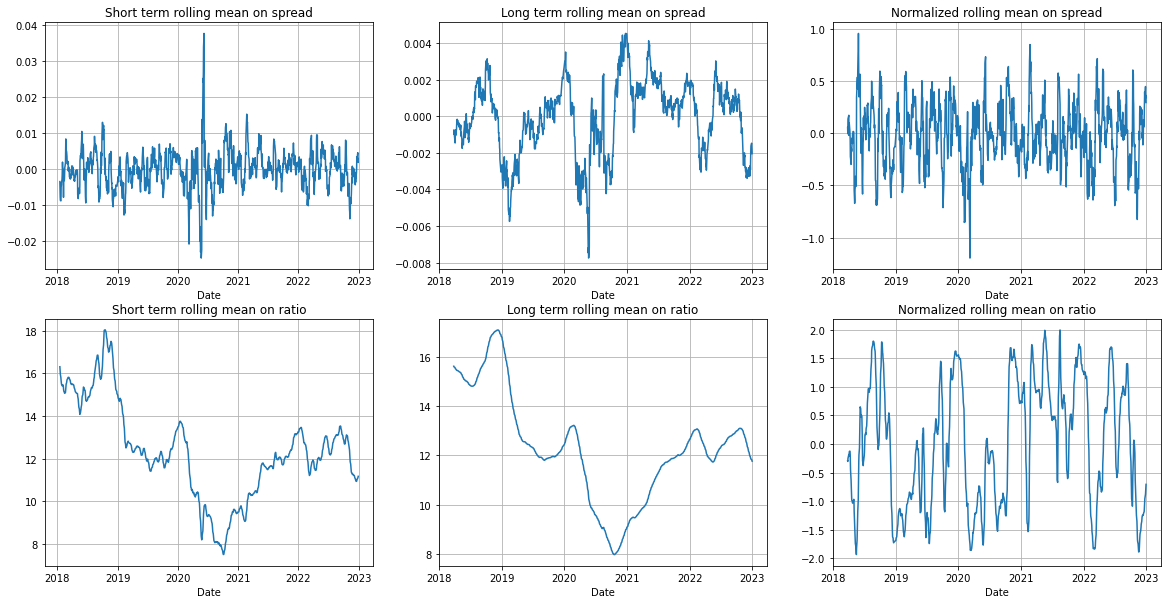

In [21]:
plot_indicator(ds_df)

### Strategy results
Spread :

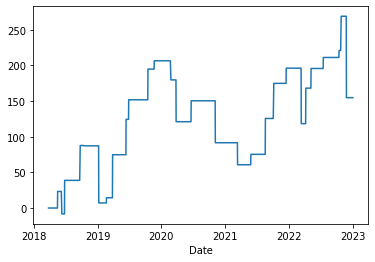

In [22]:
strat = dislocationsSignal(ds_df, "spread", 0.5, -0.1, 1000)

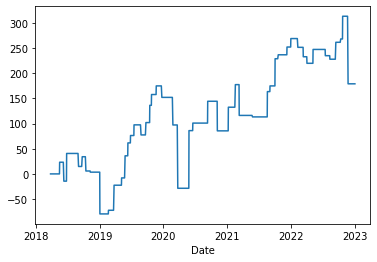

In [23]:
strat = dislocationsSignal(ds_df, "spread", 0.4, 0, 1000)

Ratio : 

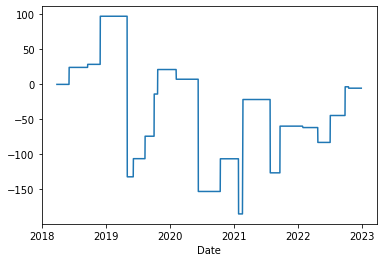

In [24]:
strat = dislocationsSignal(ds_df, "ratio", 1, 0, 1000)

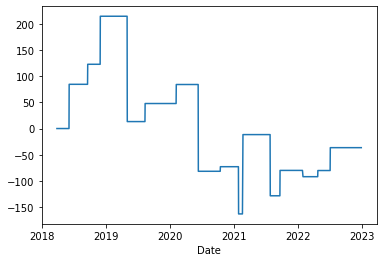

In [25]:
strat = dislocationsSignal(ds_df, "ratio", 1.5, 0, 1000)

Checking with another pair : 

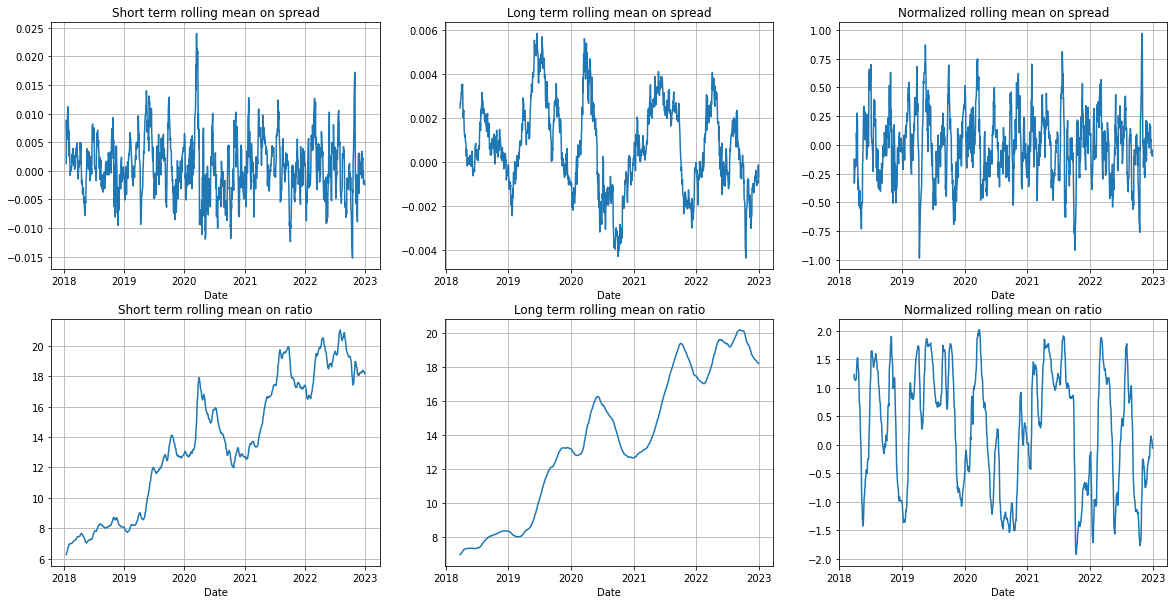

In [26]:
ds_df_2 = dislocationData(pr, ret, "ASML.AS", "IFX.DE", 10, 60)
plot_indicator(ds_df_2)

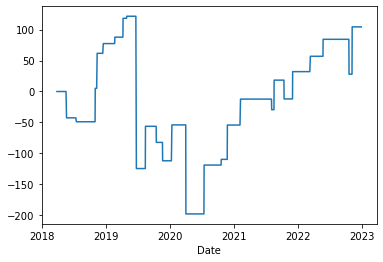

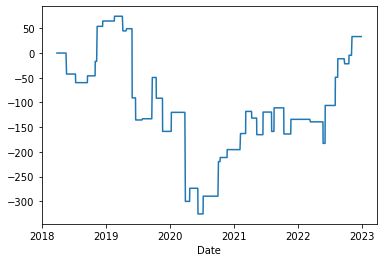

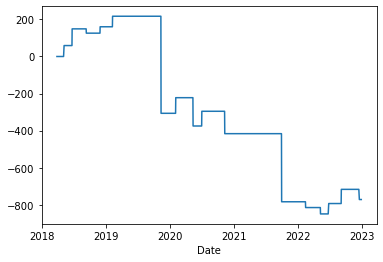

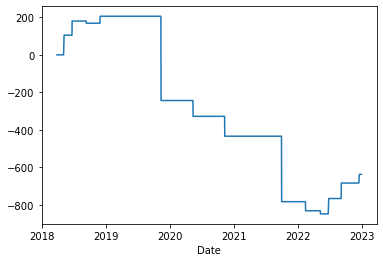

In [27]:
strat = dislocationsSignal(ds_df_2, "spread", 0.5, -0.1, 1000)
strat = dislocationsSignal(ds_df_2, "spread", 0.4, 0, 1000)
strat = dislocationsSignal(ds_df_2, "ratio", 1, 0, 1000)
strat = dislocationsSignal(ds_df_2, "ratio", 1.4, 0, 1000)

We can't see that the strategy is not working that well overall with these parameters. We can note that the spread method seems to do better here.
However, to be able to make real conclusion about the strategy implementation we would need to test and compare different thresholds and window sizes for various pairs to find the best parameters for a systematic strategy.


### Cointegration : 

Checking for high correlation is not what we actually need. We need high cointegration.

In [28]:
from statsmodels.tsa.stattools import coint

In [29]:
def cointegration_test(dislo_df, cutoff=0.01):
    # Low p-value means that there is high cointegration
    dislo_df.dropna(inplace=True)
    pvalue = coint(dislo_df["A_price"], dislo_df["B_price"])[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' Series are likely cointegrated.')
    else:
        print('p-value = ' + str(pvalue) + ' Series are likely non-cointegrated.')
    return pvalue

def coint_matrix(price_df):
    price_df.dropna(inplace=True)
    cols = price_df.columns
    n = len(cols)
    coin = np.zeros((n,n))
    for i, c in enumerate(cols):
        for j, c2 in enumerate(cols[i+1:]):
            pvalue = coint(price_df[c], price_df[c2])[1]
            coin[i, i+1+j] = pvalue
    res = pd.DataFrame(coin, columns=cols, index=cols)
    return res

def findCointegratedStocks(coint, cutoff = 0.1):
    """Find the more correlated stocks to apply dislocation strategy"""
    sorted_coint = coint.unstack().sort_values()
    scorr_df = sorted_coint.to_frame().reset_index().rename(columns={"level_0": "Ticker_1", "level_1":"Ticker_2", 0: "Cointegration"})
    scorr_df = scorr_df[scorr_df["Cointegration"] != 0]
    scorr_df = scorr_df[scorr_df["Cointegration"] <= cutoff]
    return scorr_df

In [31]:
_ = cointegration_test(ds_df)
_ = cointegration_test(ds_df_2)

p-value = 0.5174403994267915 Series are likely non-cointegrated.
p-value = 0.4747981219107165 Series are likely non-cointegrated.


The pair we choose were highly correlated but not cointegrated.

In [32]:
coint_mat = coint_matrix(pr)
coint_mat

,ASML.AS,BESI.AS,BN.PA,BUD,GLE.PA,IFX.DE,INGA.AS,ISP.MI,RI.PA
ASML.AS,0.0,0.055274,0.768603,0.682091,0.801418,0.392082,0.555064,0.166224,0.150921
BESI.AS,0.0,0.000000,0.686930,0.558745,0.789925,0.280287,0.568132,0.062832,0.180913
BN.PA,0.0,0.000000,0.000000,0.376195,0.348208,0.163475,0.328965,0.279790,0.283458
BUD,0.0,0.000000,0.000000,0.000000,0.599596,0.305835,0.654299,0.461850,0.393592
GLE.PA,0.0,0.000000,0.000000,0.000000,0.000000,0.367426,0.567605,0.514886,0.224980
IFX.DE,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.671890,0.143468,0.452184
INGA.AS,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.202570,0.251530
ISP.MI,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050102
RI.PA,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [33]:
findCointegratedStocks(coint_mat)

,Ticker_1,Ticker_2,Cointegration
45,RI.PA,ISP.MI,0.050102
46,BESI.AS,ASML.AS,0.055274
47,ISP.MI,BESI.AS,0.062832


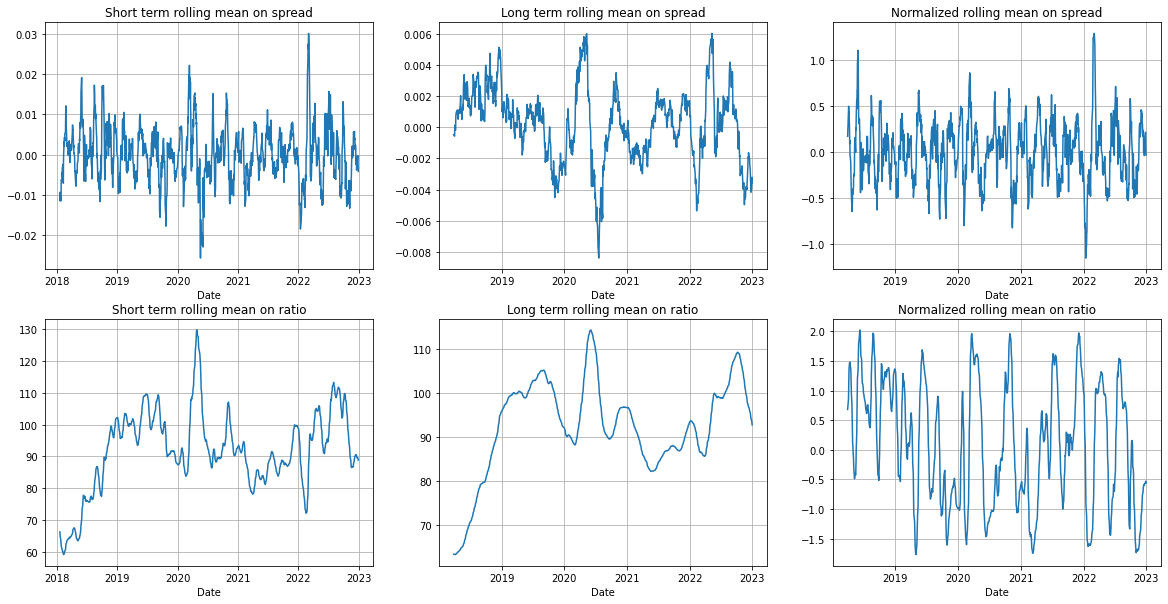

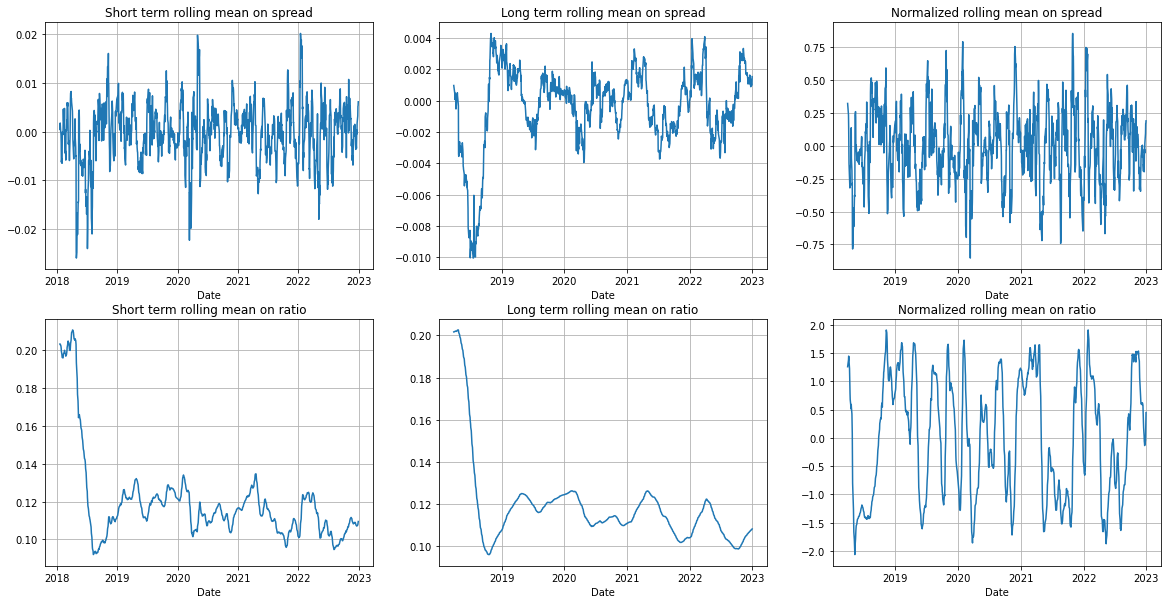

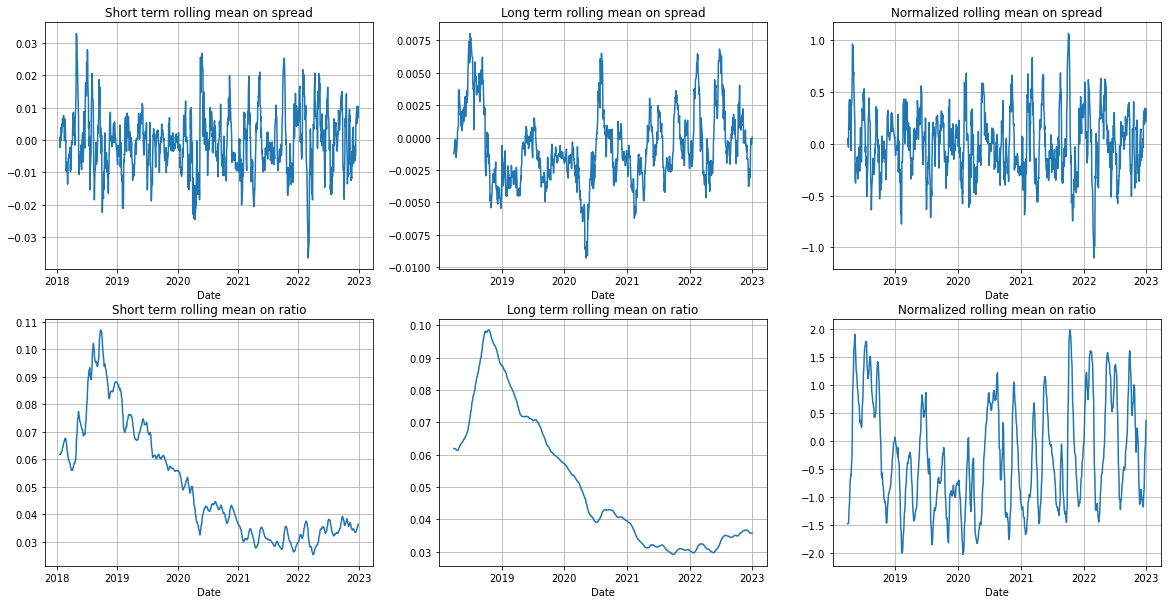

In [34]:
ds_df_3 = dislocationData(pr, ret, "RI.PA", "ISP.MI", 10, 60)
ds_df_4 = dislocationData(pr, ret, "BESI.AS", "ASML.AS", 10, 60)
ds_df_5 = dislocationData(pr, ret, "ISP.MI", "BESI.AS", 10, 60)
plot_indicator(ds_df_3)
plot_indicator(ds_df_4)
plot_indicator(ds_df_5)

RI ISP


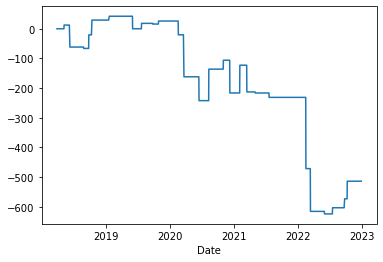

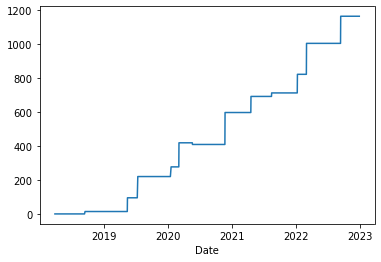

BESI ASML


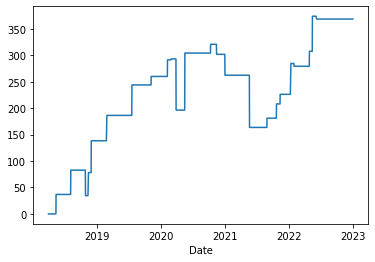

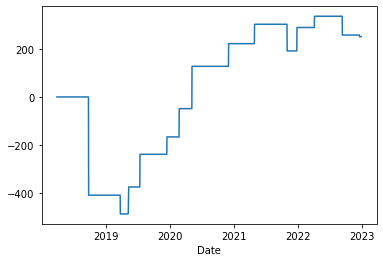

ISP BESI


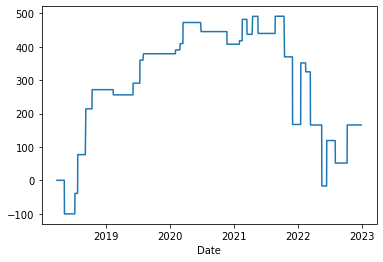

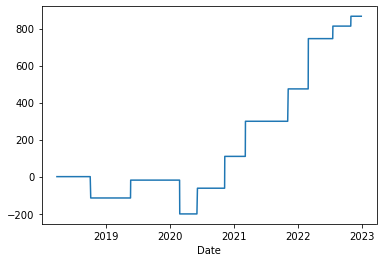

In [36]:
print("RI ISP")
strat = dislocationsSignal(ds_df_3, "spread", 0.5, 0, 1000)
strat = dislocationsSignal(ds_df_3, "ratio", 1.5, 0, 1000)
print("BESI ASML")
strat = dislocationsSignal(ds_df_4, "spread", 0.5, 0, 1000)
strat = dislocationsSignal(ds_df_4, "ratio", 1.5, 0, 1000)
print("ISP BESI")
strat = dislocationsSignal(ds_df_5, "spread", 0.5, 0, 1000)
strat = dislocationsSignal(ds_df_5, "ratio", 1.5, 0, 1000)

It seems to give better results with cointegrated assets but again, we would need a lot more back-testing to be able to draw conclusions out of it.

Also, for all the pair we tried, 0.5 seemed a good threshold for the spread method, and 1.5 a good threshold for the ratio method.

It is unclear for me at the moment which indicator between spread and ratio would be theoricaly better. And also how correlated/cointegrated the stocks need to be for our strategy to work.

#### Possible Variations : 
- We could add up to our position everyday as long as the spread remains above the open_threshold.
- Spread on normalized prices instead of returns.

### Improvements : 

Better trading rules: <br>
In this implementation, only thresholds are used to determine when to buy or sell. We could try to model the mean reverting process with models such as ARMA or Orstein_Uhlenbeck to generate more accurate trading signals. 

Consider transaction costs: <br>
In this implementation, we negliged transaction costs and slippage, which can have a big impact on pair trading models. 

Better pair picking : <br>
Back-test on various combinations of stocks to find the more profitable and reliable ones. 

Other mean-reverting indicators: <br>
We tried ratio and spread to model the relationship between A and B but we could try more complex relations. For instance, machine learning techniques such as neural networks and decision trees could be used to generate signals.

A lot of backtesting: <br>
Find best window size, thresholds, pairs, ...